# Autoencoder und Generative Models  - Exercise

###  Simple Autoencoder

Erstellen Sie wie in der Vorlesung gezeigt einen Autoencoder für das Encoding der MNIST-Daten. 

- Erstellen dazu zuerst folgende Netzwerkarchitektur:

    - Inputlayer der Größe 784
    - Zwischenlayer mit 100 Neuronen (relu activation)
    - Encoding-Layer/Latent-Space mit 2 Neuronen (linear activation)
    - Zwischenlayer mit 100 Neuronen (relu activation)
    - Outputlayer mit der Größe des Inputlayers

- Kompilieren und Trainieren Sie das Modell mit den MNIST-Daten
- Visualisieren Sie den Latent Space
- Vergleichen Sie Input/output für ein beliebiges Bild

In [1]:
import keras
from keras.models import Sequential # Sequential model API
from keras.layers import Dense, Conv2D, Conv2DTranspose, Flatten, Reshape, Lambda
from keras.models import Model      # Functional model API
from keras import Input
from keras import backend as K

import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape(60000,28*28 )
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape(10000,28*28 )

In [3]:
# Encoder Model
In  = Input(shape=(784,))
h1  = Dense(100)(In)
h2  = Dense(2)(h1) 
encoder = Model(In,h2)

# Decoder Model
dec_in = Input(K.int_shape(h2)[1:])
h3 = Dense(100)(dec_in)
Out = Dense(784)(h3)

decoder = Model(dec_in,Out)
z_decoded = decoder(h2)

model = Model(In,z_decoded)

model.compile(optimizer='rmsprop', loss='mse')
model.fit(x_train,x_train,epochs=10,batch_size=50)

W0709 11:09:30.009494 140694514198336 module_wrapper.py:139] From /opt/tljh/user/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0709 11:09:30.013096 140694514198336 module_wrapper.py:139] From /opt/tljh/user/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0709 11:09:30.018815 140694514198336 module_wrapper.py:139] From /opt/tljh/user/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0709 11:09:30.064511 140694514198336 module_wrapper.py:139] From /opt/tljh/user/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0709 11:09:30.175225 140694514198336 module_wrapper.py:139]

Epoch 1/10
60000/60000 [==============================] - 6s 93us/step - loss: 0.0591
Epoch 2/10
60000/60000 [==============================] - 5s 88us/step - loss: 0.0567
Epoch 3/10
60000/60000 [==============================] - 5s 88us/step - loss: 0.0562
Epoch 4/10
60000/60000 [==============================] - 5s 88us/step - loss: 0.0561
Epoch 5/10
60000/60000 [==============================] - 5s 88us/step - loss: 0.0561
Epoch 6/10
60000/60000 [==============================] - 5s 87us/step - loss: 0.0561
Epoch 7/10
60000/60000 [==============================] - 5s 87us/step - loss: 0.0561
Epoch 8/10
60000/60000 [==============================] - 5s 87us/step - loss: 0.0561
Epoch 9/10
60000/60000 [==============================] - 5s 86us/step - loss: 0.0561
Epoch 10/10
60000/60000 [==============================] - 5s 87us/step - loss: 0.0561


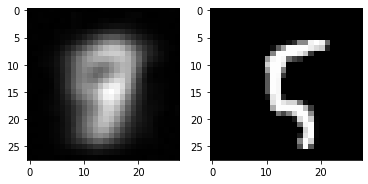

In [4]:
L = 100
plt.subplot(1,2,1)
plt.imshow(model.predict(x_train)[L,:].reshape(28,28),cmap='gray')
plt.subplot(1,2,2)
plt.imshow(x_train[L,:].reshape(28,28),cmap='gray')

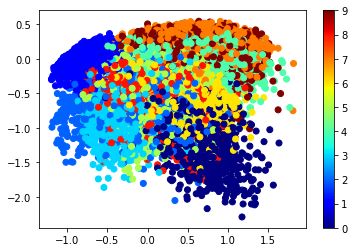

In [5]:
plt.scatter(encoder.predict(x_test)[:,0],encoder.predict(x_test)[:,1],c=y_test,cmap='jet')
plt.colorbar()

###  Variational Autoencoder

In dieser Aufgabe sollen mithilfe eines Variational Autoencoders Bilder erzeugt werden:

- Lesen Sie dazu das in der Vorlesung gezeigte Modell ein
- Rastern Sie den Latent Space im Bereich $[-4,4]\times [-4,4]$ auf einem $10\times 10$ Raster und erzeugen dann mithilfe des Decoders Bilder
- Vergleichen Sie Input/Output für ein beliebiges Bild aus dem Trainig-Set

In [6]:
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape(x_train.shape + (1,))
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape(x_test.shape + (1,))

In [7]:
img_shape = (28, 28, 1)
batch_size = 16
latent_dim = 2  

#########
# ENCODER
#########
input_img = Input(shape=img_shape)

x = Conv2D(32, 3, padding='same', activation='relu')(input_img)
x = Conv2D(64, 3, padding='same', activation='relu', strides=(2, 2))(x)
x = Conv2D(64, 3, padding='same', activation='relu')(x)
x = Conv2D(64, 3, padding='same', activation='relu')(x)
shape_before_flattening = K.int_shape(x)
x = Flatten()(x)
x = Dense(32, activation='relu')(x)

z_mean = Dense(latent_dim)(x)
z_log_var = Dense(latent_dim)(x)

def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=1.)
    return z_mean + K.exp(z_log_var) * epsilon

z = Lambda(sampling)([z_mean, z_log_var])

encoder=Model(input_img,z)

#########
# DECODER
#########
decoder_input = Input(K.int_shape(z)[1:])
x = Dense(np.prod(shape_before_flattening[1:]),activation='relu')(decoder_input)
x = Reshape(shape_before_flattening[1:])(x)
x = Conv2DTranspose(32, 3,padding='same', activation='relu', strides=(2, 2))(x)
x = Conv2D(1, 3,padding='same', activation='sigmoid')(x)

decoder = Model(decoder_input, x)
z_decoded = decoder(z)

class CustomVariationalLayer(keras.layers.Layer):

    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        xent_loss = keras.metrics.binary_crossentropy(x, z_decoded)
        kl_loss = -5e-4 * K.mean(
            1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        return x

y = CustomVariationalLayer()([input_img, z_decoded])

vae = Model(input_img, y)
vae.load_weights('vae_weights.h5')

W0709 11:14:28.614301 140694514198336 module_wrapper.py:139] From /opt/tljh/user/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4115: The name tf.random_normal is deprecated. Please use tf.random.normal instead.

W0709 11:14:28.707847 140694514198336 module_wrapper.py:139] From /opt/tljh/user/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3376: The name tf.log is deprecated. Please use tf.math.log instead.

W0709 11:14:28.713290 140694514198336 deprecation.py:323] From /opt/tljh/user/lib/python3.6/site-packages/tensorflow_core/python/ops/nn_impl.py:183: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


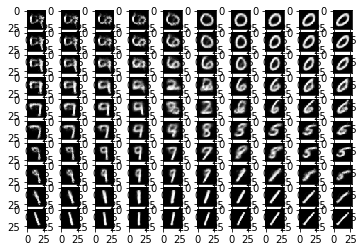

In [8]:
k = 1
for i in range(10):
    for j in range(10):
        plt.subplot(10,10,k)
        plt.imshow(decoder.predict(np.array([[-4+i*8/10,-4+j*8/10]])).reshape(28,28),cmap='gray')
        k = k+1

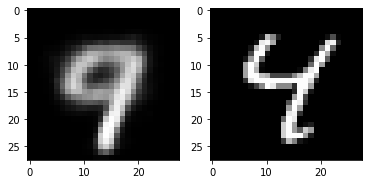

In [10]:
L = 6
plt.subplot(1,2,1)
plt.imshow(decoder.predict(encoder.predict(x_test[L,:].reshape(-1,28,28,1))).reshape(28,28),cmap='gray')
plt.subplot(1,2,2)
plt.imshow(x_test[L,:].reshape(28,28),cmap='gray')